##Description:

 Code for creating results to be presented at ESA, August 12th, 2015



# Setting variables

In [131]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/ordination/ord_raw/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [132]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [133]:
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [134]:
%%R

library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)
library(DESeq2)


In [135]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Setting files

In [136]:
!cd $workDir; ln -f -s $biomFileDir$biomFile
!cd $workDir; ln -f -s $biomFileDir'../'$metadataFile
!cd $workDir; ls -thlc

total 32K
lrwxrwxrwx 1 bryan bryan 130 Jul 27 20:08 metadata_RhizCG_merged.txt -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/..//home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt
lrwxrwxrwx 1 bryan bryan 143 Jul 27 20:08 otu_table_wtax.biom -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning//home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom
-rw-rw-r-- 1 bryan bryan 22K Jul 27 13:53 heatmap_rank2.pdf


# Loading/editting OTU table

In [137]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)

#apply gsub across columns to replace ___ w/ "", reload to phyloseq object
t = tax_table(physeq)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(physeq) = t

In [138]:
%%R
plantData = read.table('/home/bryan/RhizCG/data/MiSeq_amplicon/PlotData.txt', header = TRUE)

s = sample_data(physeq)
enz = plantData[,c(1,31:55)]
s2 = left_join(s, enz, by = c("X.sample" = "Unique"))
rownames(s2) = s2$X.sample
sample_data(physeq) = s2
sample_data(physeq) %>% head

Sample Data:        [6 samples by 46 sample variables]:
                           X.sample Library Primer_Plate Primer_Well_ID
sample2-1.06_Npos sample2-1.06_Npos       1            1             H9
sample6-4.27_Npos sample6-4.27_Npos       1            2            F11
sample4-4.27_Nneg sample4-4.27_Nneg       1            1            B12
sample4-1.06_Nneg sample4-1.06_Nneg       1            1            E11
sample2-1.06_Nneg sample2-1.06_Nneg       1            1             G9
sample6-3.07_Nneg sample6-3.07_Nneg       1            2            C11
                  primerFR_ID_byPlate primerFR_ID_total barcode_ID    PlotID
sample2-1.06_Npos                  72                72         72 1.06_Npos
sample6-4.27_Npos                  86               182        182 4.27_Npos
sample4-4.27_Nneg                  90                90         90 4.27_Nneg
sample4-1.06_Nneg                  85                85         85 1.06_Nneg
sample2-1.06_Nneg                  71                71

In [139]:
%%R
#subset out positive and negative controls
physeq = subset_samples(physeq, !is.na(DAP))
#set DAP to factor
sample_data(physeq)$DAP = factor(sample_data(physeq)$DAP)
print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


##Normalize samples and filter out taxa that are less than .0001*length(x)

In [140]:
%%R 
# filtering/normalizing
physeq.snorm = prune_samples(sample_sums(physeq) >= 10, physeq)
physeq.snorm = transform_sample_counts(physeq.snorm, function(x) x/sum(x))
  
physeq.thresh = filter_taxa(physeq.snorm, function(x) sum(x > 0) > (0.0001 * length(x)), TRUE)
print(physeq.snorm)
#physeq.thresh = physeq.snorm

print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11237 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 11237 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11237 tips and 11236 internal nodes ]


Notes: Threshold of 0.0001*length(x) removes 9 taxa, 0.01*length(x) results in 10493 taxa, 0.1*length results in 6736 taxa

## Calculate pairwise weighted Unifrac distances between samples

In [141]:
%%R
registerDoParallel(cores=28)
full.wunif.dist = phyloseq::distance(physeq.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

## NMDS of w-Unifrac

Run 0 stress 0.1404336 
Run 1 stress 0.1404264 
... New best solution
... procrustes: rmse 0.001734398  max resid 0.02544155 
Run 2 stress 0.1408885 
... procrustes: rmse 0.006894804  max resid 0.1054047 
Run 3 stress 0.1464657 
Run 4 stress 0.18652 
Run 5 stress 0.1422368 
Run 6 stress 0.1422086 
Run 7 stress 0.1470226 
Run 8 stress 0.1408977 
... procrustes: rmse 0.00721544  max resid 0.1055142 
Run 9 stress 0.1703095 
Run 10 stress 0.1550022 
Run 11 stress 0.1617737 
Run 12 stress 0.1447118 
Run 13 stress 0.1638724 
Run 14 stress 0.183943 
Run 15 stress 0.1432649 
Run 16 stress 0.1561085 
Run 17 stress 0.1526067 
Run 18 stress 0.1769904 
Run 19 stress 0.1650378 
Run 20 stress 0.1432195 


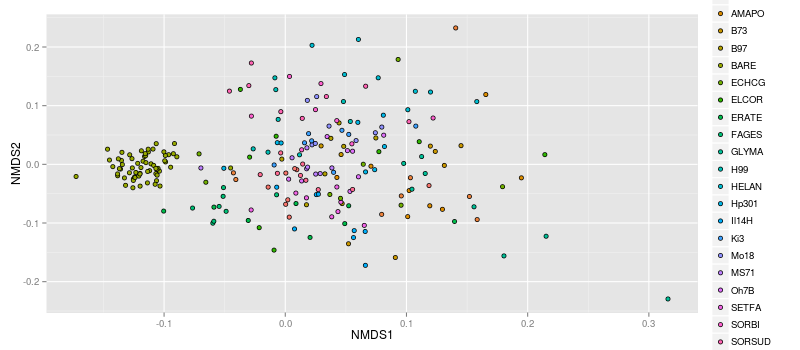

In [142]:
%%R -w 800 -h 350

nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = full.wunif.dist)

p = plot_ordination(physeq.thresh, nmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21)
        #scale_size(range=c(2,8))

##need arrange into a presentation quality graphic and save

grid.arrange(p1, ncol=1)

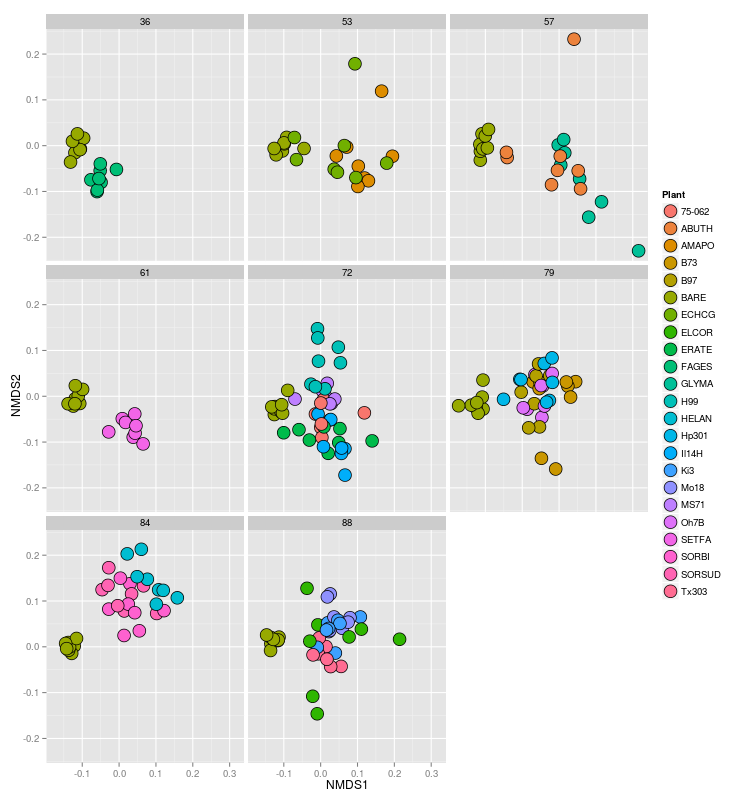

In [143]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) +
        facet_wrap(~ DAP) +
        scale_size(range=c(2,8))

p1

##Subset just plants to evaluate variation without bare soil

In [144]:
%%R

physeq.plant = subset_samples(physeq.thresh, Plant != "BARE")
physeq.plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11237 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 11237 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11237 tips and 11236 internal nodes ]


In [145]:
%%R
registerDoParallel(cores=28)
plant.wunif.dist = phyloseq::distance(physeq.plant, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [146]:
%%R -w 800 -h 350


nmds = ordinate(physeq.plant, 
                method = "NMDS", 
               distance = plant.wunif.dist)

p = plot_ordination(physeq.plant, nmds, justDF = TRUE)

Run 0 stress 0.1715634 
Run 1 stress 0.2099448 
Run 2 stress 0.1854052 
Run 3 stress 0.1893237 
Run 4 stress 0.1909602 
Run 5 stress 0.1748157 
Run 6 stress 0.1765882 
Run 7 stress 0.1894197 
Run 8 stress 0.1832111 
Run 9 stress 0.4159868 
Run 10 stress 0.1800253 
Run 11 stress 0.1851671 
Run 12 stress 0.1892422 
Run 13 stress 0.19301 
Run 14 stress 0.1805985 
Run 15 stress 0.1879093 
Run 16 stress 0.1781126 
Run 17 stress 0.2025449 
Run 18 stress 0.1742904 
Run 19 stress 0.2146605 
Run 20 stress 0.1887191 


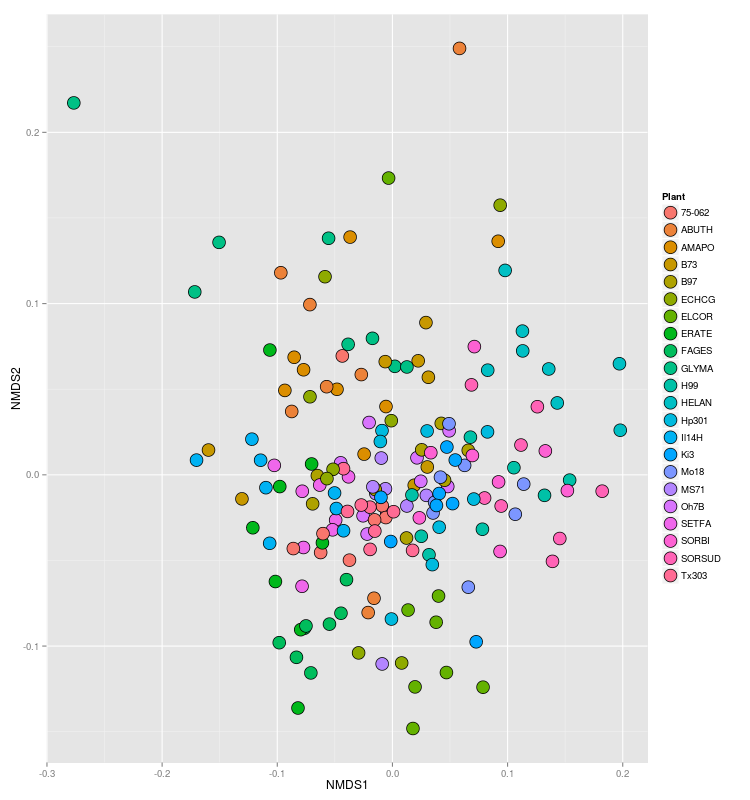

In [147]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) 

p1

###Beta-diversity hypothesis testing on plant subset 
*Note that maize/non-maize variable should be tested too, for consistency

In [148]:
%%R
df = as(sample_data(physeq.plant), "data.frame")
d = plant.wunif.dist
plantadonis = adonis(d ~ DAP*Treatment*Type, df)
plantadonis


Call:
adonis(formula = d ~ DAP * Treatment * Type, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                    Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
DAP                  7    1.3747 0.196388 12.5421 0.31514  0.001 ***
Treatment            1    0.0561 0.056105  3.5831 0.01286  0.002 ** 
Type                 4    0.3714 0.092841  5.9292 0.08513  0.001 ***
DAP:Treatment        7    0.0884 0.012629  0.8065 0.02027  0.852    
DAP:Type             1    0.0688 0.068820  4.3951 0.01578  0.001 ***
Treatment:Type       4    0.0472 0.011793  0.7531 0.01081  0.843    
DAP:Treatment:Type   1    0.0069 0.006868  0.4386 0.00157  0.942    
Residuals          150    2.3487 0.015658         0.53843           
Total              175    4.3622                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


*Note: what OTUs are influenced by fertilization treatment?

In [149]:
%%R
plant_group = get_variable(physeq.plant, "Plant")
d = plant.wunif.dist
ano1 = anosim(d, plant_group)
summary(ano1)


Call:
anosim(dat = d, grouping = plant_group) 
Dissimilarity: 

ANOSIM statistic R: 0.5935 
      Significance: 0.001 

Permutation: free
Number of permutations: 999

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0228 0.0294 0.0360 0.0417 

Dissimilarity ranks between and within classes:
         0%     25%    50%      75%  100%     N
Between   2 4132.75 7935.5 11671.25 15400 14784
75-062   42  375.50 1026.0  3040.75  8062    28
ABUTH    66 2489.75 6486.5 12922.25 15128    28
AMAPO    16  938.50 2736.0  5022.25 13028    28
B73     107  876.00 3643.0  9604.00 12055    28
B97      34  903.25 1534.5  4489.75  8921    28
ECHCG    24 4880.00 8172.5 12648.25 14618    28
ELCOR    37  486.00 1685.5  3987.25 10575    28
ERATE    18  712.75 2074.5  5171.25 14206    28
FAGES     1   16.25   75.5   317.75  2169    28
GLYMA   497 4290.75 8761.0 11616.00 15076    28
H99      69 1149.50 2812.0  4430.50  6081    28
HELAN    78 1033.75 1727.0  2865.25  8425    28
Hp301  

### Beta-diversity hypothesis tests on just maize

In [150]:
%%R
sample_data(physeq.plant) %>% colnames

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "BX_rel"              "CB_rel"              "LAP_rel"            
[25] "NAG_rel"             "BX_activity_g"       "CB_activity_g"      
[28] "LAP_activity_g"      "NAG_activity_g"      "BX_bare_factor"     
[31] "CB_bare_factor"      "LAP_bare_factor"     "NAG_bare_factor"    
[34] "BX_dif"              "CB_dif"              "LAP_dif"            
[37] "NAG_dif"             "Moisture"            "PO_Activity"        
[40] "PER_Activity"        "PO.barefactor"       "PER.barefactor"     
[43] "

In [151]:
%%R

physeq.maize = subset_samples(physeq.thresh, Type == "Maize")
physeq.maize

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11237 taxa and 88 samples ]
sample_data() Sample Data:       [ 88 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 11237 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11237 tips and 11236 internal nodes ]


In [152]:
%%R
registerDoParallel(cores=28)

maize.wunif.dist = phyloseq::distance(physeq.maize, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

Run 0 stress 0.1768911 
Run 1 stress 0.1851698 
Run 2 stress 0.1804193 
Run 3 stress 0.1806392 
Run 4 stress 0.180791 
Run 5 stress 0.1804603 
Run 6 stress 0.1980805 
Run 7 stress 0.2078761 
Run 8 stress 0.1904319 
Run 9 stress 0.185071 
Run 10 stress 0.1832223 
Run 11 stress 0.1936894 
Run 12 stress 0.2007132 
Run 13 stress 0.1804437 
Run 14 stress 0.2044787 
Run 15 stress 0.1828593 
Run 16 stress 0.1772011 
... procrustes: rmse 0.03703423  max resid 0.2257036 
Run 17 stress 0.1874825 
Run 18 stress 0.1926738 
Run 19 stress 0.2007386 
Run 20 stress 0.1805382 


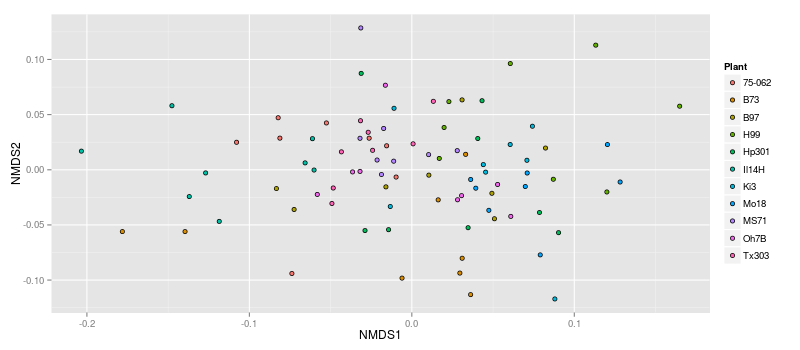

In [153]:
%%R -w 800 -h 350


nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = maize.wunif.dist)

p = plot_ordination(physeq.thresh, nmds, justDF = TRUE)


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21)
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

In [154]:
%%R
df = as(sample_data(physeq.maize), "data.frame")
d = maize.wunif.dist
plantadonis = adonis(d ~ DAP*Plant*Treatment, df)
plantadonis


Call:
adonis(formula = d ~ DAP * Plant * Treatment, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
DAP              2   0.17354 0.086771  7.1860 0.11761  0.001 ***
Plant            8   0.37344 0.046680  3.8658 0.25308  0.001 ***
Treatment        1   0.02618 0.026183  2.1683 0.01774  0.035 *  
DAP:Treatment    2   0.02640 0.013200  1.0932 0.01789  0.307    
Plant:Treatment  8   0.07904 0.009880  0.8182 0.05357  0.863    
Residuals       66   0.79695 0.012075         0.54010           
Total           87   1.47556                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [155]:
%%R
plant_group = get_variable(physeq.maize, "Plant")
d = maize.wunif.dist
ano1 = anosim(d, plant_group)
summary(ano1)


Call:
anosim(dat = d, grouping = plant_group) 
Dissimilarity: 

ANOSIM statistic R: 0.3979 
      Significance: 0.001 

Permutation: free
Number of permutations: 999

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0331 0.0447 0.0541 0.0666 

Dissimilarity ranks between and within classes:
        0%     25%    50%     75% 100%    N
Between  1 1039.75 1989.5 2929.25 3828 3520
75-062  25  270.25  673.0 1617.00 3016   28
B73     74  588.00 1851.5 3303.75 3629   28
B97     20  605.50  940.5 2136.00 3193   28
H99     45  742.75 1532.5 2125.00 2593   28
Hp301   68 1120.75 1749.5 2482.75 3251   28
Il14H    7  729.00 1188.5 2387.00 3034   28
Ki3     27  259.00  897.5 1501.25 3106   28
Mo18     4  563.00  869.5 1507.00 2663   28
MS71     2   76.50  348.0  911.25 2506   28
Oh7B     6  183.00 1304.5 1812.00 2745   28
Tx303   23  226.75  391.5  632.75 2053   28



#Test correlation between enzyme activity and microbial community composition

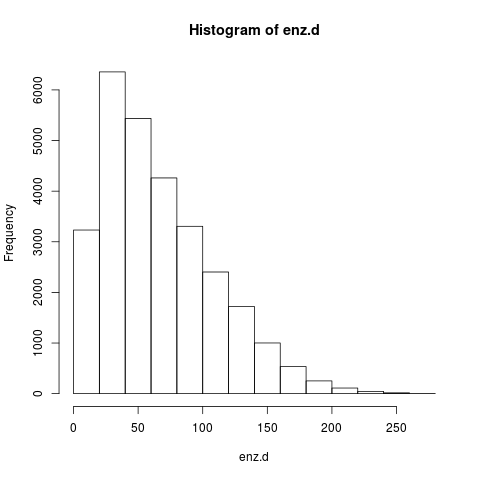

In [156]:
%%R
Sd = sample_data(physeq)
enz.d = dist(Sd[,26:29], method = "euclidian")
hist(enz.d)

In [157]:
%%R
M1 = mantel(full.wunif.dist, enz.d, method="pearson", permutations=999)
M1


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = full.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.1025 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0312 0.0414 0.0487 0.0554 
Permutation: free
Number of permutations: 999



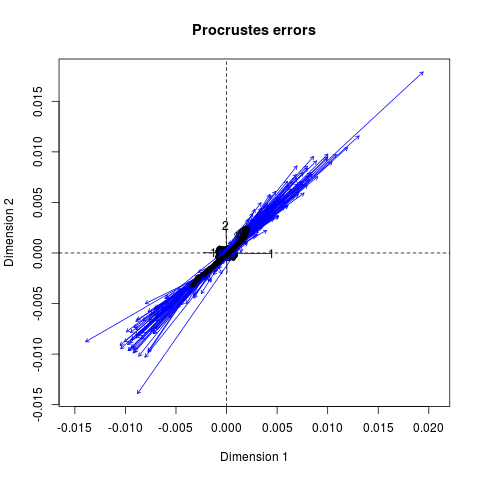

In [158]:
%%R
 p1 = protest(full.wunif.dist, enz.d, scores = "sites", permutations = 999)
plot(p1)

###Test if variation with plants is correlated with variation between plant microbial community

$breaks
 [1]   0  20  40  60  80 100 120 140 160 180 200 220 240 260

$counts
 [1] 1849 3455 2847 2329 1765 1292  933  512  235  115   47   18    3

$density
 [1] 6.003247e-03 1.121753e-02 9.243506e-03 7.561688e-03 5.730519e-03
 [6] 4.194805e-03 3.029221e-03 1.662338e-03 7.629870e-04 3.733766e-04
[11] 1.525974e-04 5.844156e-05 9.740260e-06

$mids
 [1]  10  30  50  70  90 110 130 150 170 190 210 230 250

$xname
[1] "enz.d"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = plant.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.1033 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0415 0.0531 0.0689 0.0882 
Permutation: free
Number of permutations: 999



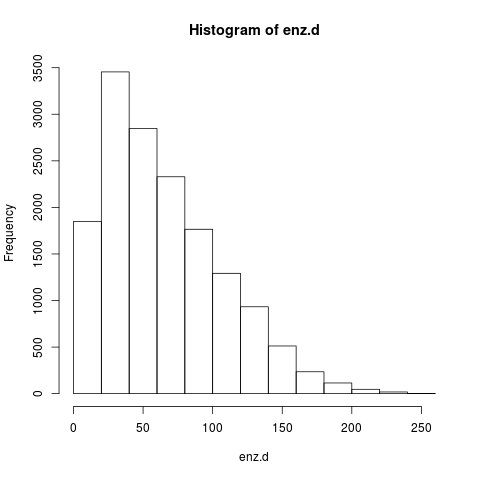

In [159]:
%%R
Sd = sample_data(physeq.plant)

enz.d = dist(Sd[,c(26:29)], method = "euclidian")

hist(enz.d) %>% print

M1 = mantel(plant.wunif.dist, enz.d, method="pearson", permutations=999)
M1 %>% print


In [160]:
%%R
colnames(Sd)

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "BX_rel"              "CB_rel"              "LAP_rel"            
[25] "NAG_rel"             "BX_activity_g"       "CB_activity_g"      
[28] "LAP_activity_g"      "NAG_activity_g"      "BX_bare_factor"     
[31] "CB_bare_factor"      "LAP_bare_factor"     "NAG_bare_factor"    
[34] "BX_dif"              "CB_dif"              "LAP_dif"            
[37] "NAG_dif"             "Moisture"            "PO_Activity"        
[40] "PER_Activity"        "PO.barefactor"       "PER.barefactor"     
[43] "

In [161]:
%%R
Sd = sample_data(physeq.maize)
enz.d = dist(Sd[,c(26:29)], method = "euclidian")
M1 = mantel(maize.wunif.dist, enz.d, method="pearson", permutations=999)
M1 %>% print



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = maize.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.02029 
      Significance: 0.355 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0684 0.0878 0.1065 0.1207 
Permutation: free
Number of permutations: 999



*Notes: once we are comparing among plants the microbial community is a predictor of enzyme activity, but not the rhizosphere effect on enzyme activity.  

Among maize inbred lines there the microbial community is not significant. 

Consider how to compare log2Fold change to change in enzyme activity

